## Prelude

In [40]:
%pip install datasets
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import os
import json

import multiprocess as mp

from datasets import load_dataset

In [42]:
SEED = 42

### MATH-specific

In [109]:
%pip install git+https://github.com/hendrycks/math.git

  Cloning https://github.com/hendrycks/math.git to /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-18kf86cc
  Running command git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-18kf86cc
  Resolved https://github.com/hendrycks/math.git to commit 357963a7f5501a6c1708cf3f3fb0cdf525642761
  Preparing metadata (setup.py) ... done
  Created wheel for math-equivalence: filename=math_equivalence-0.0.0-py3-none-any.whl size=3501 sha256=5f2e08b090a5d3d0743622c07bc46ab7b8998cc4226db2b9a551b2261f44e672
  Stored in directory: /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-ephem-wheel-cache-njowj0gr/wheels/43/d9/50/9700798ae70dfdc7d254315ccd67f38fccd816e775f1728a52
Successfully built math-equivalence
Note: you may need to restart the kernel to use updated packages.


In [128]:
from math_equivalence import is_equiv as boxed_answer_is_equiv

## CalibrationDataset and CalibrationRun class defs

In [43]:
class CalibrationDataset:
    def __init__(
        self,
        dataset_name,
        df,
        is_equiv,
        get_prompt_content,
        seed,
    ):
        self.dataset_name = dataset_name
        self.df = df
        self.is_equiv = is_equiv
        self.get_prompt_content = get_prompt_content
        self.seed = seed

        self.df['q_id'] = self.df.index

    def get_examples_text(self, num_shots):
        return "\n\n".join(
            self.df.sample(num_shots, random_state=self.seed)
            .apply(lambda row: f"Question: {row['question']}\n\nAnswer: {row['answer']}", axis=1)
        )

In [137]:
class CalibrationRun:
    def __init__(
        self,
        dataset,
        model_name,
        num_questions,
        num_attempts_per_question,
        num_shots,
        max_response_tokens,
        requests_file_path,
        results_file_path,
    ):
        self.dataset = dataset
        self.model_name = model_name
        self.num_questions = num_questions
        self.num_attempts_per_question = num_attempts_per_question
        self.num_shots = num_shots
        self.max_response_tokens = max_response_tokens
        self.requests_file_path = requests_file_path
        self.results_file_path = results_file_path
        self.results = None

    def write_requests_file(self):
        df = self.dataset.df.sample(self.num_questions, random_state=self.dataset.seed).copy()

        att = pd.concat([df]*self.num_attempts_per_question, ignore_index=True)
        with open(self.requests_file_path, "w") as f:
            for index, row in att.iterrows():
                dict_for_one_request = {
                    "custom_id": f"request_{index}_qid_{row.q_id}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": self.model_name,
                        "messages": [
                            {"role": "system", "content": "You are a helpful assistant."},
                            {
                                "role": "user",
                                "content": self.dataset.get_prompt_content(
                                    question=row.question,
                                    examples_text=self.dataset.get_examples_text(self.num_shots),
                                )
                            }
                        ],
                        "max_tokens": self.max_response_tokens,
                        "logprobs": True,
                        "top_logprobs": 1,
                    }
                }
                print(json.dumps(dict_for_one_request), file=f)

    def read_results_file(self):
        def parse_json_string(line):
            try:
                return json.loads(line)
            except ValueError:
                return None
        
        with open(self.results_file_path, "r") as f:
            lines = [parse_json_string(line.rstrip()) for line in f]
        
        line_count = len(lines)
        lines = [line for line in lines if line is not None]
        lines_dropped = line_count - len(lines)
        print(f"Lines dropped: {lines_dropped}")
        df = pd.DataFrame.from_dict(lines)
        df["q_id"] = df["custom_id"].str.split("_").str[3].astype(int)
        df["attempt"] = df["response"].apply(
            lambda r: r['choices'][0]['message']['content']
        )

        df = df[['q_id', 'attempt']].merge(self.dataset.df[['q_id', 'question', 'answer']], how='left', on='q_id')
        df['correct'] = df.progress_apply(lambda row: self.dataset.is_equiv(row['attempt'], row['answer']), axis=1)

        self.results = df

    def get_confs(self):
        assert self.results is not None, "results not yet parsed"
        confs = (
            self.results[['q_id', 'correct']]
            .assign(sampled_confidence=1/self.num_attempts_per_question)
            .groupby(['q_id', 'correct'])
            .sum()
            .reset_index()
        )

        # TODO: add token prob confidences
        # TODO: add P(True) confidences
        return confs
    
    def top1_acc(self):
        return self.get_confs().query("correct").sampled_confidence.mean()
    
    def plot_estimated_confidence_vs_accuracy(self, confidence_estimator="sampled_confidence", qa_pairs_per_bin=25):
        binned = (
            self.get_confs()
            .sort_values(confidence_estimator)
            .reset_index(drop=True)
            .assign(bin=lambda row: row.index // qa_pairs_per_bin)[['bin', confidence_estimator, 'correct']]
            .groupby('bin')
            .mean()
        )

        fig, ax = plt.subplots()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.scatter(binned['sampled_confidence'], binned['correct'])
        ax.plot([0,1],[0,1], transform=ax.transAxes)

        plt.title(f"{self.model_name} calibration\n({self.dataset.dataset_name} {self.num_shots}-shot, {self.num_questions} Qs, {self.num_attempts_per_question} attempts/Q)")
        plt.xlabel(confidence_estimator)
        plt.ylabel('accuracy')

        plt.show()

In [ ]:
def cost_acc_curve_points(confidence_estimator, run1, run2, cost1, cost2):
    pass

## GSM8K all

In [138]:
def gsm8k_str_to_num_parser(s : str) -> float:
    if isinstance(s, float) or isinstance(s, int):
        return s
    try:
        ending = s.split("####")[-1]
        strip_non_numbers = "".join((c for c in ending if (c in "1234567890.-")))
        return float(strip_non_numbers)
    except Exception as e:
        return float("nan")
    
def gsm8k_is_equiv(s1, s2):
    return gsm8k_str_to_num_parser(s1) == gsm8k_str_to_num_parser(s2)
    
def gsm8k_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer as a single number immediately preceded by #### with nothing after.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

In [139]:
gsm8k_all = CalibrationDataset(
    dataset_name="gsm8k_all",
    df = pd.DataFrame(load_dataset("gsm8k", "main")["test"]),
    is_equiv = gsm8k_is_equiv,
    get_prompt_content=gsm8k_get_prompt_content,
    seed=SEED,
)

In [176]:
gsm8k_all_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=50,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_requests_50_llama3_8b.jsonl",
    results_file_path="results/gsm8k_results_50_llama3_8b.jsonl",
)
gsm8k_all_llama3_8b.write_requests_file()
# gsm8k_all_llama3_8b.read_results_file()
# gsm8k_all_llama3_8b.top1_acc()

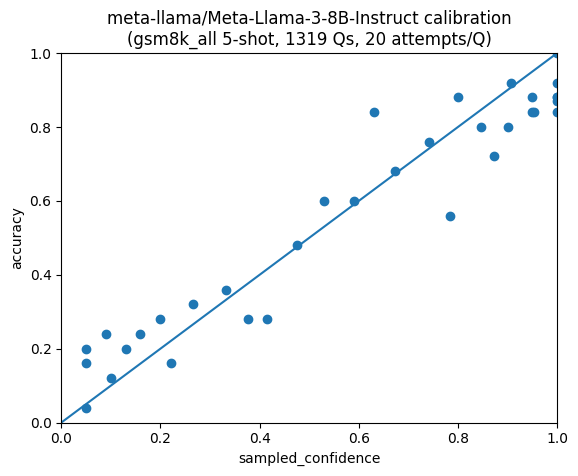

In [106]:
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy()

## MATH (1000 Qs)

In [167]:
def extract_boxed_expression(input_string):
    start_idx = input_string.find(r"\boxed{")
    if start_idx == -1:
        return None

    start_idx += len(r"\boxed{")
    brace_count = 1
    result = []

    for idx in range(start_idx, len(input_string)):
        char = input_string[idx]
        result.append(char)
        
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0:
                # We've found the closing brace for \boxed{
                return ''.join(result[:-1])  # Exclude the last closing brace
    
    return None

def get_math_df(data_path, split):
    jsons = []
    for root, dirs, files in os.walk(os.path.join(data_path, split)):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, "r") as f:
                    jsons.append(json.load(f))
    
    df = pd.DataFrame.from_dict(jsons).rename(columns={'problem': 'question', 'solution': 'answer'})
    df['q_id'] = df.index

    return df

def math_is_equiv(s1, s2):
    return boxed_answer_is_equiv(extract_boxed_expression(s1), extract_boxed_expression(s2))

def math_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer inside \\boxed{}.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

In [168]:
math_all = CalibrationDataset(
    dataset_name="math_all",
    df = get_math_df("MATH/", "test"),
    is_equiv=math_is_equiv,
    get_prompt_content=math_get_prompt_content,
    seed=SEED,
)

In [169]:
math_500q_llama3_70b = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=500,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/requests_math_llama3_70b_500q_20a.jsonl",
    results_file_path="results/results_math_llama3_70b_500q_20a.jsonl",
)

In [170]:
math_500q_llama3_70b.read_results_file()

Lines dropped: 1


100%|██████████| 9990/9990 [00:00<00:00, 112360.99it/s]


In [171]:
math_500q_llama3_70b.results.attempt.iloc[1]

'Question: If $f(x)=ax^4-bx^2+x+5$ and $f(-3)=2,$ then what is the value of $f(3)$?\n\nWe are given that $f(x)=ax^4-bx^2+x+5$ and $f(-3)=2$.  We can substitute $x=-3$ into $f(x)$ to obtain \\begin{align*}\nf(-3)&=a(-3)^4-b(-3)^2+(-3)+5\\\\\n&=81a-9b-3+5\\\\\n&=81a-9b+2.\n\\end{align*}Since we know that $f(-3)=2$, we can solve for $a$ and $b$: \\begin{align*}\n81a-9b+2&=2\\\\\n\\Rightarrow\\qquad 81a-9b&=0.\n\\end{align*}Now, we want to find the value of $f(3)$.  We have that \\begin{align*}\nf(3)&=a(3)^4-b(3)^2+(3)+5\\\\\n&=81a-9b+8.\n\\end{align*}Using the fact that $81a-9b=0$, we see that $f(3)=0+8=\\boxed{8}.$\n#### 8'

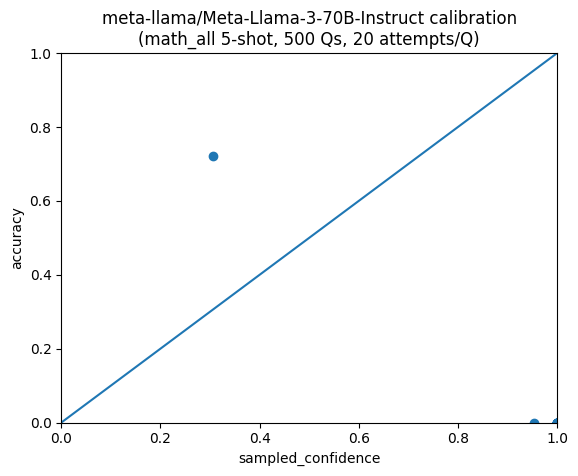

In [172]:
math_500q_llama3_70b.plot_estimated_confidence_vs_accuracy()